 <img src="logo.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />
     
# Quantum Self-Introduction Game

Welcome everyone to the first event of the Meet Up group Quantum Barcelona. The organizers already know each other, but most of them do not know most of the people who have joined us in this launching meeting. 

We would like this Meet Up group to be a safe place where all people can talk with anyone abuout Quantum Computing. In our opinion, the mixture of different people coming from different places (not only countries or cities, but also backgrounds and jobs) is what enriches the world and societies. Let us use this game to introduce ourselves. 

The dinamycs of the game is very easy. Every one will introduce him/herself with his/her name and what is the main purpose for being part of this group. In addition, we would like you to tell us the fact about Quantum Computing that most impresses you. As a constraint, this fact should not be part of the mainstream features of QC.

It does not matter whether the name is official or just a nickname, we will not analyze it. However, we will dive into your reasons to be part of this #qBCNmeetup and will classify the attendants to this events in two different groups (group |0>, group |1>). With the help of Quantum Computers, we will implement a quantum algorithm to look for all the people belonging to the group |1>. 

### However

Not everything in life is Quantum Computing. One of the aims of this group is to create a relaxed space where talking and conversation flow. We have performed an optimization with some of the most powerful quantum computers in the world and have come to the following conclusion: 
##### The best way to achieve that is with a pair of drinks around the table

We would be ashamed to admit that we will be the first ones to order a virtual beer, so let us Quantum Mechanics and Decoherence be the judges deciding who gets a beer and who does not. We will add an extra qubit in the former quantum system. this _beer_ qubit will not interact with any other qubit, but some operations will be applied to it. If the noise is null, nobody will have a beer. If the noise does something, then some of us will take a beer, and some of us will have to wait. It is up to you to wish that the noise is large or not.

##### Let us start

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel, thermal_relaxation_error

provider = IBMQ.load_account()

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


First, we will load all different packages needed to play. We will use the package Qiskit, since it is well known and allows us to play in an actual Quantum Computer. However, for the sake of speed, we will only use simulators.

Now, we will record the introductions of all people. Note that only the first 16 to talk will be included (this is QC, not democracy)

Let us skip now to the circuit

In [67]:
## INPUTS
participant_names = [
                    ['Sergio', 'Eat sandwiches and drink beer'], 
                    ['Carmen', 'Learn Quantum Computing with other people'], 
                    ['Adrian', 'Improve my german skills'], 
                    ['Alfonso', 'Increase my knowledge of Quantum'],
                    ['Michail', 'To meet other people interested in quantum computing, and have fun :))) I would like to learn more about quantum computing. I have only a small experience with QISkit, but it has been like...ages ago. Would like to explore other quantum frameworks as well.'], 
                    ['John', 'New ideas for projects. Networking.'], 
                    ['Ricard Soler i Kopp', 'Learn more about our (Catalonia) relevance/leadership/talent in the quantum world'], 
                    ['Pep Lluis Molinet', 'To entangle with all meetup participants :-)'],
                    ['Avantika Agarwal', 'Get better knowledge of how to move forward in the field as an undergraduate student'], 
                    ['Javier', 'Meet lots of people with similar interests. May be here or there Im in Madrid)'], 
                    ['Adrian3', 'Improve my german skills'], 
                    ['Alfonso3', 'Increase my knowledge of Quantum'],
                    ['Sergio4', 'Eat sandwiches and drink beer'], 
                    ['Carmen4', 'Learn Quantum Computing with other people'], 
                    ['Adrian4', 'Improve my german skills'], 
                    ['Alfonso4', 'Increase my knowledge of Quantum'],
                    ]

In [68]:
# Create the qubits needed dynamically based on the final attendees, and generate the participants list in a way that our program understands it
len(participant_names[0])
qubits = len(bin(len(participant_names)-1)[2:])
binary_length = '{0:0'+str(qubits)+'b}'

participants = {}
for idx, participant in enumerate(participant_names):
    #print(binary_length.format(idx))
    participants[str(binary_length.format(idx))] = participant


In [69]:
# Generate the opinion array with a very simple check. If you come to learn, you are in! :D
feed_keywords = ['knowledge', 'learn', 'learning', 'discover']
opinion = []

for participant in participants:
    num = 0
    for i in feed_keywords:
        num += participants[participant][1].lower().count(i.lower())

    if(num > 0):
        opinion.append(0)
    else:
        opinion.append(1)

#opinion = list(np.random.binomial(1, 1/30, len(participants))) # habrá que borrarlo en el último paso
opinion

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]

In [70]:
def add_oracle(circuit, qubits, number):
    ctrls = np.binary_repr(number, width=qubits)
    for i, c in enumerate(ctrls):
        if c == '1':
            circuit.x(qubits - i - 1)
    
    circuit.mct(list(range(qubits)), qubits)
            
    for i, c in enumerate(ctrls):
        if c == '1':
            circuit.x(qubits - i - 1)
    

In [71]:
def circuit(C, qubits, opinion):
    for q in range(qubits):
        C.h(q)
    for i, o in enumerate(opinion):
        if o == 1:
            add_oracle(C, qubits, i)
    C.barrier()
            
def circuit_inverse(C, qubits, opinion):
    opinion.reverse()
    for i, o in enumerate(opinion):
        if o == 1:
            add_oracle(C, qubits, 2**qubits - 1 - i)
    for q in range(qubits):
        C.h(q)
    opinion.reverse()
    C.barrier()
            
def oracle(C):
    C.z(qubits)
    C.barrier()
    
def diffusion(C, qubits):
    
    for q in range(qubits + 1):
        C.x(q)
    C.h(qubits)
    C.mct(list(range(qubits)), qubits)
    C.h(qubits)
    for q in range(qubits + 1):
        C.x(q)
    
    C.barrier()

In [72]:
def create_circuit(qubits, iterations, opinion, beers=True):
    C = QuantumCircuit()

    qr_people = QuantumRegister(qubits,'people')
    cr_people = ClassicalRegister(qubits, 'c_people')
    C.add_register(qr_people)
    C.add_register(cr_people)

    qr_opinion = QuantumRegister(1, 'opinion')
    cr_opinion = ClassicalRegister(1, 'c_opinion')
    C.add_register(qr_opinion)
    C.add_register(cr_opinion)

    qr_beer = QuantumRegister(1, 'beer')
    cr_beer = ClassicalRegister(1, 'c_beer')
    C.add_register(qr_beer)
    C.add_register(cr_beer)
    
    
    if beers:
        C.h(qubits + 1)
        C.barrier()
        
    circuit(C, qubits, opinion)
    
    for i in range(iterations):
        oracle(C)
        circuit_inverse(C, qubits, opinion)
        diffusion(C, qubits)
        circuit(C, qubits, opinion)
        
    if beers:
        C.barrier()
        C.h(qubits + 1)
        
    for i in range(qubits + 2):
        C.measure(i,i)
        
    return C

 <img src="circuit.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />

In [73]:
print(opinion.count(1))
print(opinion)
repeats = int(np.round(np.pi / 4 * np.sqrt(len(opinion) / opinion.count(1))))

print('The best possible Grover search needs %s repeats' %repeats)
C = create_circuit(qubits, repeats, opinion)

C.draw()

8
[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
The best possible Grover search needs 1 repeats


░ ┌───┐               ┌───┐     ┌───┐┌───┐     ┌───┐┌───┐»
   people_0: ──────░─┤ H ├──■─────────■──┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├»
                   ░ ├───┤  │  ┌───┐  │  ├───┤  │  ├───┤└───┘  │  ├───┤└───┘»
   people_1: ──────░─┤ H ├──■──┤ X ├──■──┤ X ├──■──┤ X ├───────■──┤ X ├─────»
                   ░ ├───┤  │  └───┘  │  ├───┤  │  ├───┤┌───┐  │  ├───┤     »
   people_2: ──────░─┤ H ├──■─────────■──┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├─────»
                   ░ ├───┤  │         │  └───┘  │  └───┘└───┘  │  ├───┤     »
   people_3: ──────░─┤ H ├──■─────────■─────────■──────────────■──┤ X ├─────»
                   ░ └───┘┌─┴─┐     ┌─┴─┐     ┌─┴─┐          ┌─┴─┐└───┘     »
  opinion_0: ──────░──────┤ X ├─────┤ X ├─────┤ X ├──────────┤ X ├──────────»
             ┌───┐ ░      └───┘     └───┘     └───┘          └───┘          »
     beer_0: ┤ H ├─░────────────────────────────────────────────────────────»
             └───┘ ░                                                        »
 c_people: 4/═══════════════════════════════════════════════════════════════»
                                                                            »
c_opinion: 1/═══════════════════════════════════════════════════════════════»
                                                                            »
   c_beer: 1/═══════════════════════════════════════════════════════════════»
                                                                            »
«                  ┌───┐                                              ░      »
«   people_0: ──■──┤ X ├───────■──────────────■──────────────■────────░──────»
«               │  ├───┤       │  ┌───┐       │  ┌───┐       │  ┌───┐ ░      »
«   people_1: ──■──┤ X ├───────■──┤ X ├───────■──┤ X ├───────■──┤ X ├─░──────»
«               │  └───┘       │  ├───┤       │  ├───┤┌───┐  │  ├───┤ ░      »
«   people_2: ──■──────────────■──┤ X ├───────■──┤ X ├┤ X ├──■──┤ X ├─░──────»
«               │  ┌───┐┌───┐  │  ├───┤┌───┐  │  ├───┤├───┤  │  ├───┤ ░      »
«   people_3: ──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├─░──────»
«             ┌─┴─┐└───┘└───┘┌─┴─┐└───┘└───┘┌─┴─┐└───┘└───┘┌─┴─┐└───┘ ░ ┌───┐»
«  opinion_0: ┤ X ├──────────┤ X ├──────────┤ X ├──────────┤ X ├──────░─┤ Z ├»
«             └───┘          └───┘          └───┘          └───┘      ░ └───┘»
«     beer_0: ────────────────────────────────────────────────────────░──────»
«                                                                     ░      »
« c_people: 4/═══════════════════════════════════════════════════════════════»
«                                                                            »
«c_opinion: 1/═══════════════════════════════════════════════════════════════»
«                                                                            »
«   c_beer: 1/═══════════════════════════════════════════════════════════════»
«                                                                            »
«              ░                                         ┌───┐          ┌───┐»
«   people_0: ─░────────■──────────────■──────────────■──┤ X ├───────■──┤ X ├»
«              ░ ┌───┐  │  ┌───┐       │  ┌───┐       │  ├───┤       │  ├───┤»
«   people_1: ─░─┤ X ├──■──┤ X ├───────■──┤ X ├───────■──┤ X ├───────■──┤ X ├»
«              ░ ├───┤  │  ├───┤┌───┐  │  ├───┤       │  └───┘       │  ├───┤»
«   people_2: ─░─┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├───────■──────────────■──┤ X ├»
«              ░ ├───┤  │  ├───┤├───┤  │  ├───┤┌───┐  │  ┌───┐┌───┐  │  ├───┤»
«   people_3: ─░─┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├»
«              ░ └───┘┌─┴─┐└───┘└───┘┌─┴─┐└───┘└───┘┌─┴─┐└───┘└───┘┌─┴─┐└───┘»
«  opinion_0: ─░──────┤ X ├──────────┤ X ├──────────┤ X ├──────────┤ X ├─────»
«              ░      └───┘          └───┘          └───┘          └───┘     »
«     beer_0: ─░─────────────────────────────────────────────────────────────»
«              ░                                                             »
« c_peopl

In [74]:
noisy_backend = provider.get_backend('ibmq_santiago')
noise_model = NoiseModel.from_backend(noisy_backend)
T1 = 0.01
T2 = 0.02
error = 0.01
thermal_error = thermal_relaxation_error(T1, T2, error)
noise_model.add_quantum_error(thermal_error, "h", [qubits+1])

{'0 0 0000': 222, '0 0 0001': 8, '0 1 0000': 18, '0 1 0001': 215, '0 1 0010': 24, '0 1 0011': 215, '0 1 0100': 16, '0 1 0101': 232, '0 1 0110': 215, '0 1 0111': 28, '0 1 1000': 208, '0 1 1001': 29, '0 1 1010': 209, '0 1 1011': 21, '0 1 1100': 18, '0 1 1101': 220, '0 1 1110': 16, '0 1 1111': 236, '0 0 0010': 210, '1 0 0000': 14, '1 0 0001': 1, '1 0 0010': 11, '1 0 0100': 20, '1 0 0101': 1, '1 0 0111': 17, '1 0 1000': 6, '1 0 1001': 11, '1 0 1011': 16, '1 0 1100': 25, '1 0 1101': 2, '1 0 1110': 12, '1 0 1111': 2, '0 0 0011': 10, '1 1 0000': 2, '1 1 0001': 26, '1 1 0010': 1, '1 1 0011': 18, '1 1 0100': 1, '1 1 0101': 18, '1 1 0110': 14, '1 1 0111': 1, '1 1 1000': 16, '1 1 1001': 2, '1 1 1010': 21, '1 1 1011': 2, '1 1 1100': 1, '1 1 1101': 14, '1 1 1111': 26, '0 0 0100': 212, '0 0 0101': 8, '0 0 0110': 20, '0 0 0111': 187, '0 0 1000': 14, '0 0 1001': 215, '0 0 1010': 17, '0 0 1011': 226, '0 0 1100': 204, '0 0 1101': 6, '0 0 1110': 207, '0 0 1111': 13}


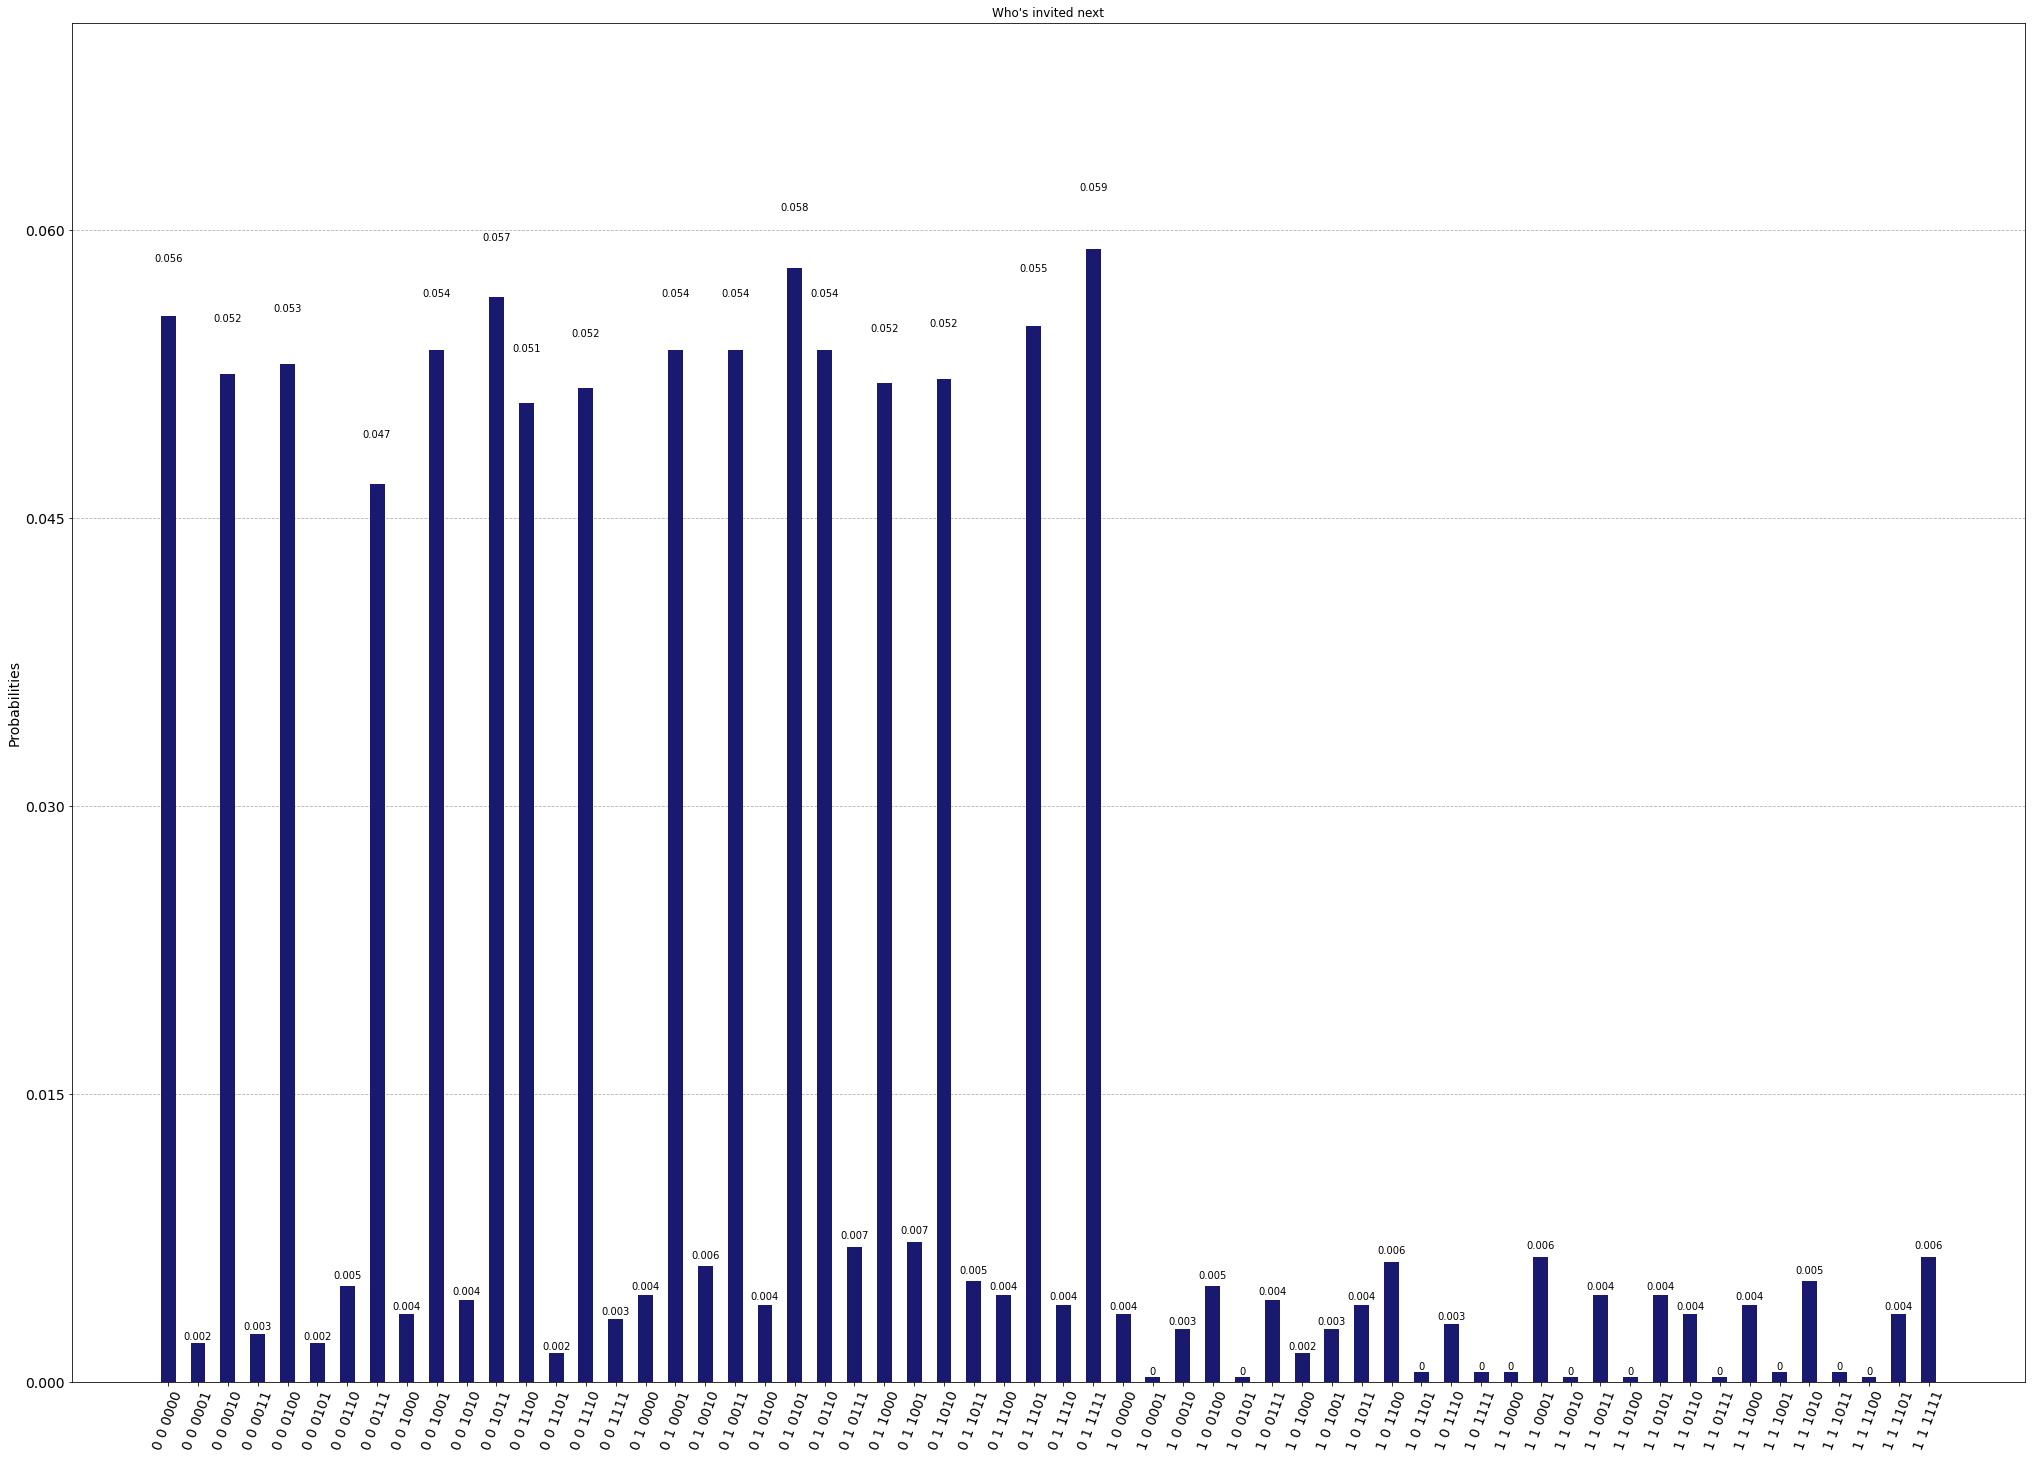

In [142]:
simulator = Aer.get_backend('qasm_simulator') 
shots = 4000
job_noisy = execute(C, simulator, shots=shots, noise_model=noise_model)
result_noisy = job_noisy.result()
counts_noisy = result_noisy.get_counts(C)
print(counts_noisy); # print the results of the runs
plot_histogram(counts_noisy, figsize=(35, 25), color='midnightblue', title="Who's invited next") # Visualise the results

In [76]:
noise_model.to_dict

<bound method NoiseModel.to_dict of NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'u2', 'u3']
  Instructions with noise: ['id', 'measure', 'u2', 'u3', 'h', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [2, 1]), ('cx', [2, 3]), ('cx', [3, 2]), ('cx', [3, 4]), ('cx', [4, 3]), ('h', [5]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]>

In [140]:
for p in participants:

    if('0 0 '+str(p) not in counts_noisy): counts_noisy['0 0 '+str(p)] = 0
    if('0 1 '+str(p) not in counts_noisy): counts_noisy['0 1 '+str(p)] = 0
    if('1 0 '+str(p) not in counts_noisy): counts_noisy['1 0 '+str(p)] = 0
    if('1 1 '+str(p) not in counts_noisy): counts_noisy['1 1 '+str(p)] = 0
    
    no_luck = counts_noisy['1 0 '+str(p)] + counts_noisy['0 0 '+str(p)]
    luck = counts_noisy['1 1 '+str(p)] + counts_noisy['0 1 '+str(p)]
    
    if(luck > no_luck):
        print(participants[p][0], " 🤗 you really got it. Awesome! You are invited to the next one!")
    else:
        print(participants[p][0],", 😢😢 Ooops, maybe next time!")

    drink = counts_noisy['1 1 '+str(p)]
    no_drink = counts_noisy['0 0 '+str(p)]
    if(drink > no_drink):
        print("      🍻🍻 And you also get a Beer! 🍻🍻")
    print(" ")
        

Sergio , 😢😢 Ooops, maybe next time!
 
Carmen  🤗 you really got it. Awesome! You are invited to the next one!
      🍻🍻 And you also get a Beer! 🍻🍻
 
Adrian , 😢😢 Ooops, maybe next time!
 
Alfonso  🤗 you really got it. Awesome! You are invited to the next one!
      🍻🍻 And you also get a Beer! 🍻🍻
 
Michail , 😢😢 Ooops, maybe next time!
 
John  🤗 you really got it. Awesome! You are invited to the next one!
      🍻🍻 And you also get a Beer! 🍻🍻
 
Ricard Soler i Kopp  🤗 you really got it. Awesome! You are invited to the next one!
 
Pep Lluis Molinet , 😢😢 Ooops, maybe next time!
 
Avantika Agarwal  🤗 you really got it. Awesome! You are invited to the next one!
      🍻🍻 And you also get a Beer! 🍻🍻
 
Javier , 😢😢 Ooops, maybe next time!
 
Adrian3  🤗 you really got it. Awesome! You are invited to the next one!
      🍻🍻 And you also get a Beer! 🍻🍻
 
Alfonso3 , 😢😢 Ooops, maybe next time!
 
Sergio4 , 😢😢 Ooops, maybe next time!
 
Carmen4  🤗 you really got it. Awesome! You are invited to the next one!
 

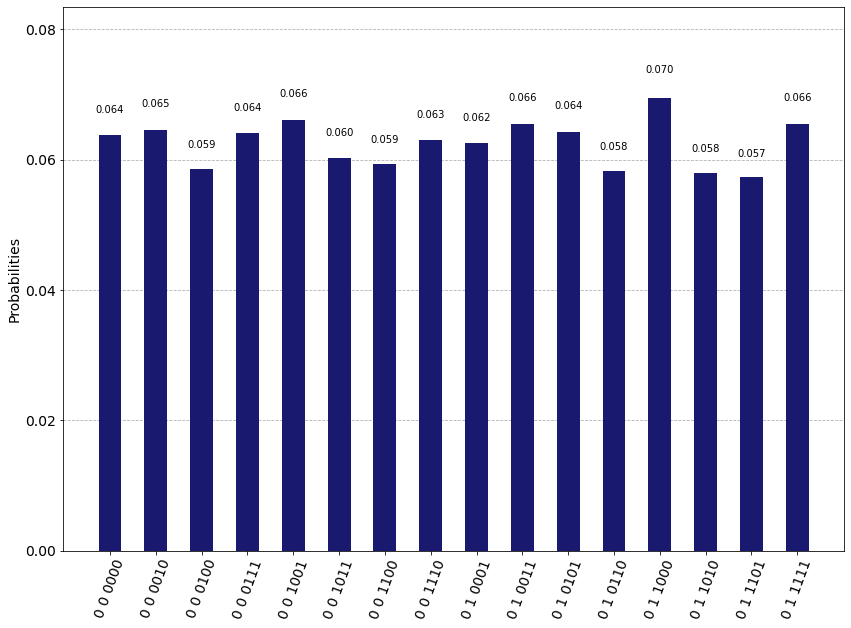

In [141]:
job_noiseless = execute(C, simulator, shots=shots)
result_noiseless = job_noiseless.result()
counts_noiseless = result_noiseless.get_counts(C)
plot_histogram(counts_noiseless, figsize=(14,10), color="midnightblue")

In [143]:
probabilities = np.zeros((len(participants), 4))
for c in counts_noisy:
    result = c.split()
    probabilities[int(result[2], base=2), 2 * int(result[0])+int(result[1])] = counts_noisy[c]


probabilities /= np.sum(probabilities)

S = np.sum(probabilities, axis=1)

for i, (p, s) in enumerate(zip(probabilities, S)):
    if s > 0:
        probabilities[i] = p / s

probabilities

array([[0.8671875 , 0.0703125 , 0.0546875 , 0.0078125 ],
       [0.032     , 0.86      , 0.004     , 0.104     ],
       [0.85365854, 0.09756098, 0.04471545, 0.00406504],
       [0.04115226, 0.88477366, 0.        , 0.07407407],
       [0.85140562, 0.06425703, 0.08032129, 0.00401606],
       [0.03088803, 0.8957529 , 0.003861  , 0.06949807],
       [0.08032129, 0.86345382, 0.        , 0.0562249 ],
       [0.80257511, 0.12017167, 0.07296137, 0.00429185],
       [0.05737705, 0.85245902, 0.02459016, 0.06557377],
       [0.83657588, 0.11284047, 0.04280156, 0.0077821 ],
       [0.06882591, 0.84615385, 0.        , 0.08502024],
       [0.85283019, 0.07924528, 0.06037736, 0.00754717],
       [0.82258065, 0.07258065, 0.10080645, 0.00403226],
       [0.02479339, 0.90909091, 0.00826446, 0.05785124],
       [0.88085106, 0.06808511, 0.05106383, 0.        ],
       [0.04693141, 0.85198556, 0.00722022, 0.09386282]])

In [144]:
# Who knows the main goal of the group?
threshold = np.mean(S)
for i, s in enumerate(S):
    if s > threshold:
        idx = np.binary_repr(i, int(np.ceil(np.log2(len(participants)))))
        print('Congrats,', participants[idx][0], '! You know why we are here.', participants[idx][1])
    

Congrats, Sergio ! You know why we are here. Eat sandwiches and drink beer
Congrats, John ! You know why we are here. New ideas for projects. Networking.
Congrats, Javier ! You know why we are here. Meet lots of people with similar interests. May be here or there Im in Madrid)
Congrats, Alfonso3 ! You know why we are here. Increase my knowledge of Quantum
Congrats, Alfonso4 ! You know why we are here. Increase my knowledge of Quantum


 
------------------------
WHO DRINKS?


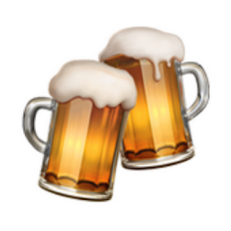

Congrats, Alfonso ! Quantum mechanics wants you to grab a beer now.
Congrats, Avantika Agarwal ! Quantum mechanics wants you to grab a beer now.
Congrats, Adrian3 ! Quantum mechanics wants you to grab a beer now.
Congrats, Alfonso3 ! Quantum mechanics wants you to grab a beer now.
Congrats, Adrian4 ! Quantum mechanics wants you to grab a beer now.
 
 
------------------------
WHO DOES NOT?


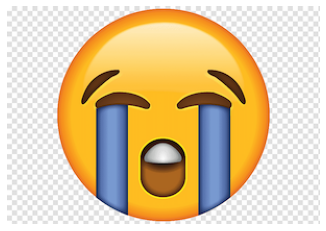

Sorry, Sergio . Quantum mechanics decided that you will have to wait until the next round.
Sorry, Carmen . Quantum mechanics decided that you will have to wait until the next round.
Sorry, Adrian . Quantum mechanics decided that you will have to wait until the next round.
Sorry, Michail . Quantum mechanics decided that you will have to wait until the next round.
Sorry, John . Quantum mechanics decided that you will have to wait until the next round.
Sorry, Ricard Soler i Kopp . Quantum mechanics decided that you will have to wait until the next round.
Sorry, Pep Lluis Molinet . Quantum mechanics decided that you will have to wait until the next round.
Sorry, Javier . Quantum mechanics decided that you will have to wait until the next round.
Sorry, Sergio4 . Quantum mechanics decided that you will have to wait until the next round.
Sorry, Carmen4 . Quantum mechanics decided that you will have to wait until the next round.
Sorry, Alfonso4 . Quantum mechanics decided that you will have to

In [145]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Who is gonna get a beer right now?
print(" ")
print("------------------------")
print("WHO DRINKS?")
img = mpimg.imread('beer.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()
for i, prob in enumerate(Probabilities):
    idx = np.binary_repr(i, int(np.ceil(np.log2(len(participants)))))
    if prob[2] + prob [3] > .08:
        print('Congrats,', participants[idx][0], '! Quantum mechanics wants you to grab a beer now.')

print(" ")
print(" ")
print("------------------------")
print("WHO DOES NOT?")
img = mpimg.imread('sad.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

for i, prob in enumerate(Probabilities):
    idx = np.binary_repr(i, int(np.ceil(np.log2(len(participants)))))
    if prob[2] + prob [3] <= .08:
        print('Sorry,', participants[idx][0], '. Quantum mechanics decided that you will have to wait until the next round.')

print("------------------------")
